<a href="https://colab.research.google.com/github/woutervantol/scriptie1/blob/master/SCRIPTIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
!pip install hcipy
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
# from perlin_noise import PerlinNoise
import time
from tensorflow import keras
from IPython.display import clear_output
from mpl_toolkits.axes_grid1 import make_axes_locatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Utils

In [2]:
def split_pwfs_img(pwfs_img):
  pwfs_img = pwfs_img.reshape(len(pwfs_img), num_pwfs_pixels, num_pwfs_pixels)
  data = np.ndarray((len(pwfs_img), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4))
  h = int(num_pwfs_pixels/2)
  data[:,:,:,0] = pwfs_img[:, :h, :h]
  data[:,:,:,1] = pwfs_img[:, h:, :h]
  data[:,:,:,2] = pwfs_img[:, :h, h:]
  data[:,:,:,3] = pwfs_img[:, h:, h:]
  return data

def get_rms(data):
  rms = np.sqrt(np.sum(data**2, axis=(1, 2)) / np.sum(aperture))
  return rms

def modavg(modlist):
  avg = np.zeros(num_pwfs_pixels**2)
  for i in range(len(modlist)):
    avg += modlist[i].intensity / len(modlist)
  return avg / np.sum(avg)

# Choose modebasis


In [3]:
use_modulation = False
use_zernike = True

#these texts are used to easily import the right files below
if use_modulation:
  mod_text = "Mod"
else:
  mod_text = ""

if use_zernike:
  zernike_text = "Zernike"
else:
  zernike_text = ""

#Sync data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


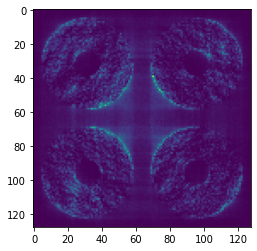

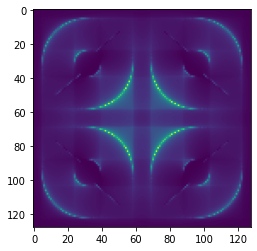

In [4]:
#Sync data with drive
from google.colab import drive
drive.mount('/content/gdrive')

#save data
# !cp /content/image_refMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/image_ref.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp -r /content/models/cnnmodel "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrix.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainx.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainy.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testx.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testy.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrixMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainxMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainyMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testxMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testyMod.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrixZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainxZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainyZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testxZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testyZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"

# !cp /content/reconstructionMatrixModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainxModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/trainyModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testxModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"
# !cp /content/testyModZernike.npy "/content/gdrive/MyDrive/MasterThesis/Data/"


image_ref = np.load("/content/gdrive/MyDrive/MasterThesis/Data/image_ref{}.npy".format(mod_text))
model = keras.models.load_model("/content/gdrive/MyDrive/MasterThesis/Data/cnnmodel")

matrix = np.load("/content/gdrive/MyDrive/MasterThesis/Data/reconstructionMatrix{}{}.npy".format(mod_text, zernike_text))
trainx = np.load("/content/gdrive/MyDrive/MasterThesis/Data/trainx{}{}.npy".format(mod_text, zernike_text))
trainy = np.load("/content/gdrive/MyDrive/MasterThesis/Data/trainy{}{}.npy".format(mod_text, zernike_text))
testx = np.load("/content/gdrive/MyDrive/MasterThesis/Data/testx{}{}.npy".format(mod_text, zernike_text))
testy = np.load("/content/gdrive/MyDrive/MasterThesis/Data/testy{}{}.npy".format(mod_text, zernike_text))
plt.imshow(trainx[600])
plt.show()
plt.imshow(image_ref)
# plt.savefig("image_ref_unmodulated.png", dpi=500)
plt.show()

# Initialisation

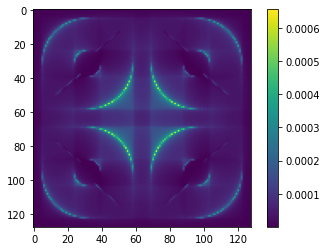

In [5]:
#initialization
wavelength_wfs = 1e-6
to_m = wavelength_wfs/(2*np.pi) #translate rad to meters
to_rad = (2*np.pi)/wavelength_wfs #translate meters to rad
telescope_diameter = 6.5 #39.3 #in meters
# zero_magnitude_flux = 3.9E10
num_pupil_pixels = 256
num_pwfs_pixels = 128
pupil_grid_diameter = telescope_diameter
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)
pwfs_grid = make_pupil_grid(num_pwfs_pixels, 1.2*2*pupil_grid_diameter)
focal_grid = make_focal_grid(q=8, num_airy=20, spatial_resolution=wavelength_wfs / telescope_diameter)
num_focal_pixels = int(np.sqrt(len(focal_grid)))

# make_aperture = make_elt_aperture()
make_aperture = make_magellan_aperture()
aperture = evaluate_supersampled(make_aperture, pupil_grid, 6)



if use_zernike:
  num_zernike_modes = 400
  influence_functions = make_zernike_basis(num_zernike_modes, telescope_diameter, pupil_grid)
  wf_to_modes = inverse_tikhonov(influence_functions.transformation_matrix, rcond=1e-3, svd=None) / 2
  modes_to_wf = influence_functions.transformation_matrix * 2
else:
  num_actuators_across_pupil = 20
  num_gaussian_modes = num_actuators_across_pupil**2
  actuator_spacing = telescope_diameter / num_actuators_across_pupil
  influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing)
  wf_to_modes = inverse_tikhonov(influence_functions.transformation_matrix, rcond=1e-3, svd=None) / 2
  modes_to_wf = influence_functions.transformation_matrix.toarray() * 2


modes_variance = np.sqrt(np.var(trainy))/2 + np.sqrt(np.var(testy))/2

nr_runs = 100
rmslist = np.logspace(np.log10(0.01), np.log10(4.0), 10)

deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

pwfs = PyramidWavefrontSensorOptics(pupil_grid, pwfs_grid, separation=1.2*pupil_grid_diameter, pupil_diameter=telescope_diameter, wavelength_0=wavelength_wfs, q=4)
mpwfs = ModulatedPyramidWavefrontSensorOptics(pwfs, 3*wavelength_wfs/telescope_diameter)
wf_flat = Wavefront(aperture, wavelength_wfs)





if use_modulation:
  image_ref = modavg(mpwfs.forward(wf_flat)).reshape(num_pwfs_pixels, num_pwfs_pixels)
else:
  image_ref = pwfs.forward(wf_flat).intensity.reshape(num_pwfs_pixels, num_pwfs_pixels)
  image_ref /= np.sum(image_ref)
plt.imshow(image_ref)
plt.colorbar()
plt.show()
np.save("./image_ref{}".format(mod_text), image_ref)

#Generate reconstruction matrix

In [55]:
#generate reconstruction matrix
def make_reconstruction_matrix(rcond=1e-15):
  probe_amp = 0.01 * wavelength_wfs /(2*np.pi) #rad omrekenen naar m
  slopes = []

  for ind in range(num_modes):
    if ind % 20 == 0:
      print("Measure response to mode {:d} / {:d}".format(ind+1, num_modes))
    slope = 0

    for s in [1, -1]:
      amp = np.zeros((num_modes,))
      amp[ind] = s * probe_amp
      deformable_mirror.actuators = amp
      dm_wf = deformable_mirror.forward(wf_flat)

      if use_modulation:
        wfs_wf = mpwfs.forward(dm_wf)
        image = modavg(wfs_wf)
      else:
        wfs_wf = pwfs.forward(dm_wf)
        image = wfs_wf.intensity
        image /= np.sum(image)
      slope += s * (image-image_ref.flatten())/(2 * probe_amp)
    slopes.append(slope)
  slopes = ModeBasis(slopes)
  matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd=None)
  return matrix

matrix = make_reconstruction_matrix(rcond=1e-1)
np.save("./reconstructionMatrix{}{}".format(mod_text, zernike_text), matrix)

Measure response to mode 1 / 400
Measure response to mode 21 / 400
Measure response to mode 41 / 400
Measure response to mode 61 / 400
Measure response to mode 81 / 400
Measure response to mode 101 / 400
Measure response to mode 121 / 400
Measure response to mode 141 / 400
Measure response to mode 161 / 400
Measure response to mode 181 / 400
Measure response to mode 201 / 400
Measure response to mode 221 / 400
Measure response to mode 241 / 400
Measure response to mode 261 / 400
Measure response to mode 281 / 400
Measure response to mode 301 / 400
Measure response to mode 321 / 400
Measure response to mode 341 / 400
Measure response to mode 361 / 400
Measure response to mode 381 / 400


#calculate best rcond

In [ ]:
#calculate best rcond
measurements = np.zeros((len(testx), num_pwfs_pixels, num_pwfs_pixels))
h = int(num_pwfs_pixels/2)
measurements[:, :h, :h] = testx[:, :, 0].reshape(len(testx), h, h)
measurements[:, h:, :h] = testx[:, :, 1].reshape(len(testx), h, h)
measurements[:, :h, h:] = testx[:, :, 2].reshape(len(testx), h, h)
measurements[:, h:, h:] = testx[:, :, 3].reshape(len(testx), h, h)
measurements = measurements.reshape(len(testx), num_pwfs_pixels**2)
label_wf = np.matmul(testy, modes_to_wf.transpose())


outputs = []
inputs = np.logspace(-2, -1, 4)
print(inputs)
for i in inputs:
  rcondtestmatrix = make_reconstruction_matrix(i)
  predictions_modes = np.matmul(measurements - image_ref[None,:], rcondtestmatrix.transpose())
  predictions_wf = np.matmul(predictions_modes, modes_to_wf.transpose())
  rms = np.sqrt(np.sum((predictions_wf - label_wf)**2, axis=1) / np.sum(aperture)) *to_rad
  outputs.append(np.average(rms))
  print(outputs[-1], i)

plt.loglog(inputs, outputs)
plt.xlabel("rcond")
plt.ylabel("rms of linear reconstruction")
plt.show()
print(outputs)
print(inputs)

In [ ]:
plt.loglog(inputs, outputs)
plt.xlabel("rcond")
plt.ylabel("rms of linear reconstruction")
plt.show()
print(outputs)
print(inputs)

#Generate Data

In [14]:
#generate data
def make_phase_abberation(rms):
  amplitude = rms*to_m
  if use_zernike:
    phase_aberration = make_power_law_error(pupil_grid, 1, telescope_diameter, exponent=-2, aperture=aperture)
    phase_aberration[aperture >= 0.5] -= np.mean(phase_aberration[aperture >= 0.5])
    phase_aberration = phase_aberration / get_rms(phase_aberration.reshape(1, 256, 256)) * amplitude
    return phase_aberration
  else:
    aberration_modes = np.random.randn(int(np.sqrt(num_modes)), int(np.sqrt(num_modes))).flatten()
    phase_aberration = np.matmul(modes_to_wf, aberration_modes) * aperture
    phase_aberration = phase_aberration / get_rms(phase_aberration.reshape(1, 256, 256)) * amplitude
    return phase_aberration

def makeData(rms):
  perfect_phase_abberation = make_phase_abberation(rms)*to_rad
  perfect_wf = Wavefront(aperture * np.exp(1j * perfect_phase_abberation), wavelength_wfs)
  label_modes = np.matmul(wf_to_modes, perfect_phase_abberation)*to_m #constrained to 400 modes
  
  
  if use_modulation:
    mpwfs_wf = mpwfs.forward(perfect_wf)
    image = modavg(mpwfs_wf)
  else:
    image = pwfs.forward(perfect_wf).intensity
    image /= np.sum(image)
  nr_photons = 1e6
  image = np.random.poisson(image*nr_photons)
  image = image/np.sum(image)
  
  return image.reshape(num_pwfs_pixels, num_pwfs_pixels), label_modes


In [50]:
#trainingdata
def generate_data():
  trainx = np.ndarray((nr_runs*len(rmslist), num_pwfs_pixels, num_pwfs_pixels))
  trainy = np.ndarray((nr_runs*len(rmslist), num_modes))
  for run in range(nr_runs):
    for rms_idx in range(len(rmslist)):
      measurement, label_modes = makeData(rmslist[rms_idx])
      rowposition = rms_idx * nr_runs + run
      trainy[rowposition] = label_modes
      trainx[rowposition] = measurement
    if run%10 == 0:
      print(run, nr_runs)
  np.save("./trainx{}{}".format(mod_text, zernike_text), trainx)
  np.save("./trainy{}{}".format(mod_text, zernike_text), trainy)


  #testdata
  testx = np.ndarray((nr_runs*len(rmslist), num_pwfs_pixels, num_pwfs_pixels))
  testy = np.ndarray((nr_runs*len(rmslist), num_modes))
  for run in range(nr_runs):
    for rms_idx in range(len(rmslist)):
      measurement, label_modes = makeData(rmslist[rms_idx])
      rowposition = rms_idx * nr_runs + run
      testy[rowposition] = label_modes
      testx[rowposition] = measurement
    if run%10 == 0:
      print(run, nr_runs)
  np.save("./testx{}{}".format(mod_text, zernike_text), testx)
  np.save("./testy{}{}".format(mod_text, zernike_text), testy)

generate_data()

0 100
10 100
20 100
30 100
40 100
50 100
60 100
70 100
80 100
90 100
0 100
10 100
20 100
30 100
40 100
50 100
60 100
70 100
80 100
90 100


# Check data generation

/usr/local/lib/python3.8/dist-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


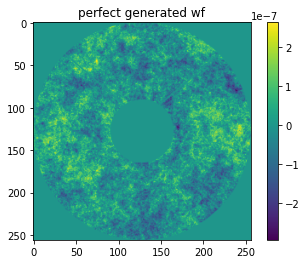

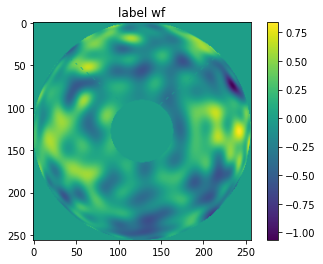

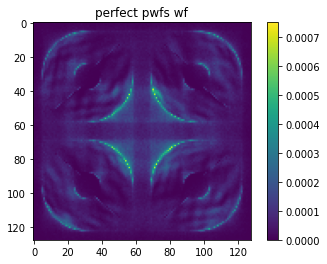

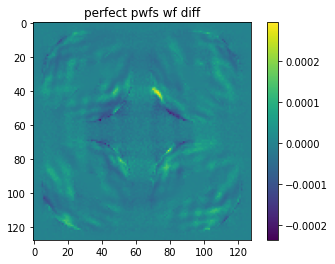

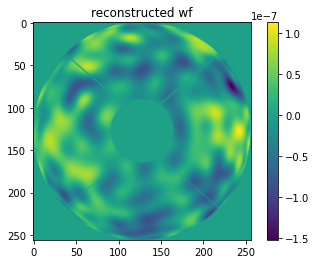

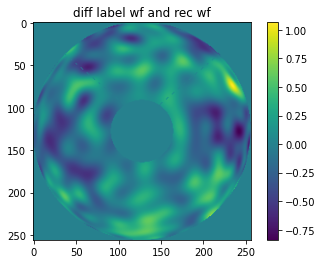

(1000, 128, 128)


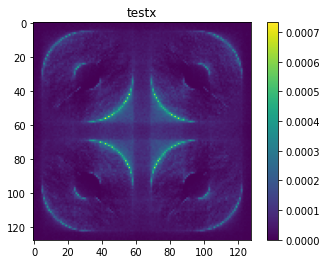

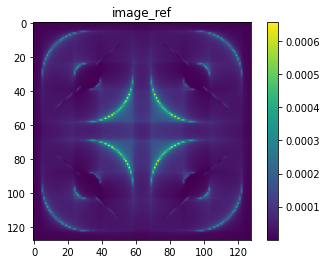

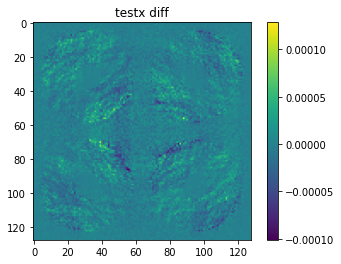

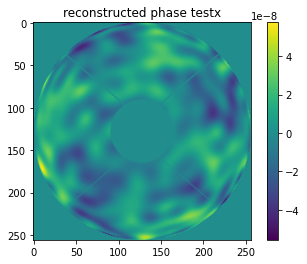

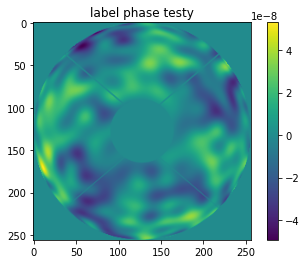

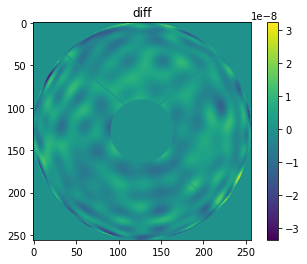

In [15]:
perfect_phase_abberation = make_phase_abberation(0.4)
plt.imshow(perfect_phase_abberation.reshape(num_pupil_pixels, num_pupil_pixels))
plt.title("perfect generated wf")
plt.colorbar()
plt.show()

modes = np.matmul(wf_to_modes, perfect_phase_abberation)
label_phase = np.matmul(modes_to_wf, modes)*to_rad
label_wf = Wavefront(aperture * np.exp(1j * label_phase), wavelength_wfs)
plt.imshow(label_wf.phase.reshape(num_pupil_pixels, num_pupil_pixels))
plt.title("label wf")
plt.colorbar()
plt.show()

image = pwfs.forward(label_wf).intensity.reshape(num_pwfs_pixels, num_pwfs_pixels)
image = image / np.sum(image)
image = np.random.poisson(image*1e6)
image = image / np.sum(image)
plt.imshow(image)
plt.title("perfect pwfs wf")
plt.colorbar()
plt.show()

plt.imshow((image - image_ref))
plt.title("perfect pwfs wf diff")
plt.colorbar()
plt.show()

reconstructed_modes = np.matmul((image - image_ref).flatten(), matrix.transpose())

reconstructed_wf = np.matmul(modes_to_wf, reconstructed_modes)*aperture
plt.imshow(reconstructed_wf.reshape(num_pupil_pixels, num_pupil_pixels))
plt.title("reconstructed wf")
plt.colorbar()
plt.show()

plt.imshow((reconstructed_wf-label_wf.phase).reshape(num_pupil_pixels, num_pupil_pixels))
plt.title("diff label wf and rec wf")
plt.colorbar()
plt.show()


########
index = 400
print(testx.shape)
plt.imshow(testx[index])
plt.title("testx")
plt.colorbar()
plt.show()

plt.imshow(image_ref.reshape(num_pwfs_pixels, num_pwfs_pixels))
plt.title("image_ref")
plt.colorbar()
plt.show()

plt.imshow((testx[index]-image_ref).reshape(num_pwfs_pixels, num_pwfs_pixels))
plt.title("testx diff")
plt.colorbar()
plt.show()



reconstructed_modes = np.matmul((testx - image_ref).reshape(len(testx), num_pwfs_pixels**2), matrix.transpose())#meter
reconstructed_wf = np.matmul(reconstructed_modes, modes_to_wf.transpose())*aperture#meter
plt.imshow(reconstructed_wf[index].reshape(num_pupil_pixels, num_pupil_pixels))
plt.title("reconstructed phase testx")
plt.colorbar()
plt.show()

label_phases = np.matmul(testy, modes_to_wf.transpose())
plt.imshow((label_phases[index]*aperture).reshape(num_pupil_pixels, num_pupil_pixels))
plt.title("label phase testy")
plt.colorbar()
plt.show()

plt.imshow((label_phases[index]*aperture - reconstructed_wf[index]).reshape(num_pupil_pixels, num_pupil_pixels))
plt.title("diff")
plt.colorbar()
plt.show()


#Plot response

In [ ]:
#plot response
def response(mode, aberration_amp=0):
  inputs = np.linspace(-1, 1, 20)
  outputs = []
  aberrated_wf = make_aberrated_wf(aberration_amp)
  for i in inputs:
    if zernike:
      modes = np.matmul(wf_to_modes, aberrated_wf.phase*wavelength_wfs/(2*np.pi))
      modes[mode] = i * wavelength_wfs/(2*np.pi)
      deformable_mirror.actuators = modes
      wf_in = deformable_mirror.forward(wf_flat)
      if use_modulation:
        wfs_wf = mpwfs.forward(wf_in)
        image = modavg(wfs_wf)
      else:
        wfs_wf = pwfs.forward(wf_in)
        image = wfs_wf.intensity
        image /= np.sum(image)
      mvmprediction = np.matmul(matrix, image-image_ref)
      outputs.append(mvmprediction[mode] / wavelength_wfs * (2*np.pi))
      # plt.imshow(wf_in.phase.reshape(256, 256))
      # plt.colorbar()
      # plt.show()
      # deformable_mirror.actuators = mvmprediction
      # wf_in = deformable_mirror.forward(wf_flat)
      # plt.imshow(wf_in.phase.reshape(256, 256))
      # plt.colorbar()
      # plt.show()
      
    else:
      amplitude = i * wavelength_wfs /(2*np.pi) * aberration_amp
      aberration = np.random.randn(np.sqrt(num_modes), np.sqrt(num_modes)).flatten() * amplitude

      amplitude = i * wavelength_wfs /(2*np.pi)
      amps = np.zeros((num_modes,))
      # amps = aberration
      amps[int((num_modes)/2) - 5] = amplitude
      deformable_mirror.actuators = amps
      dm_wf = deformable_mirror.forward(wf_flat)
      amplitude = rms*wavelength_wfs/(2*np.pi)
      aberration = np.random.randn(np.sqrt(num_modes), np.sqrt(num_modes)).flatten() * amplitude
      deformable_mirror.actuators = aberration
      wf_in = deformable_mirror.forward(wf_flat)
      if use_modulation:
        wfs_wf = mpwfs.forward(wf_in)
        image = modavg(wfs_wf)
      else:
        wfs_wf = pwfs.forward(wf_in)
        image = wfs_wf.intensity
        image /= np.sum(image)
      matrixprediction = np.matmul(matrix, image - image_ref)
      output = matrixprediction[int((num_modes)/2)-5] / wavelength_wfs *(2*np.pi)
      outputs.append(output)
  return inputs, outputs



# plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls="dashed", lw=1)
# for aberrationamp in [0, 0.1, 0.5, 1, 1.5, 2, 2.5]:
#   response()(aberrationamp)
# plt.legend()
# plt.show()

# for mode in range(8):
#   inputs, outputs = response(mode, 0.5)
#   plt.plot(inputs, outputs, label="mode {}".format(mode))
#   print(mode)
# plt.plot(np.linspace(-0.5, 0.5, 10), np.linspace(-0.5, 0.5, 10), ls="dashed", color="black")
# plt.legend()
# plt.savefig("response_zernikemodes.png", dpi=500)
# plt.show()

# response(2, 0.1)

inputs, outputs1 = response(6, 0)
outputs2 = np.zeros(20)
for i in range(10):
  inputs, outputs = response(6, 0.5)
  outputs2 += outputs
outputs2 /= 10


/usr/local/lib/python3.8/dist-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


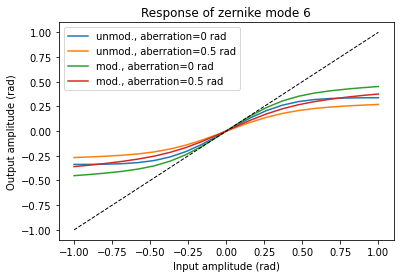

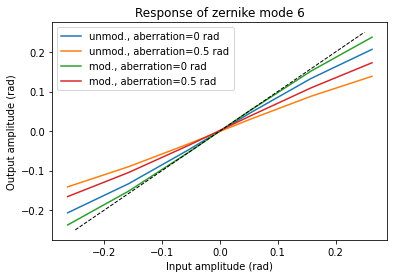

In [ ]:
plt.plot(inputs, outputs1, label="unmod., aberration=0 rad")
plt.plot(inputs, outputs2, label="unmod., aberration=0.5 rad")
plt.plot(inputs, outputs3, label="mod., aberration=0 rad")
plt.plot(inputs, outputs4, label="mod., aberration=0.5 rad")
plt.plot(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), ls="dashed", lw=1, color="black")
plt.legend()
plt.xlabel("Input amplitude (rad)")
plt.ylabel("Output amplitude (rad)")
plt.title("Response of zernike mode 6")
plt.savefig("response.png", dpi=500)
plt.show()

plt.plot(inputs[7:13], outputs1[7:13], label="unmod., aberration=0 rad")
plt.plot(inputs[7:13], outputs2[7:13], label="unmod., aberration=0.5 rad")
plt.plot(inputs[7:13], outputs3[7:13], label="mod., aberration=0 rad")
plt.plot(inputs[7:13], outputs4[7:13], label="mod., aberration=0.5 rad")
plt.plot(np.linspace(-0.25, 0.25, 10), np.linspace(-0.25, 0.25, 10), ls="dashed", lw=1, color="black")
plt.legend()
plt.xlabel("Input amplitude (rad)")
plt.ylabel("Output amplitude (rad)")
plt.title("Response of zernike mode 6")
plt.savefig("response_zoom.png", dpi=500)
plt.show()


#Model from paper

In [38]:
#PAPER MODEL
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), data_format="channels_last"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", strides=2, padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(4, (1, 1), padding="same"))
model.add(keras.layers.BatchNormalization())
# model.add(layers.Dropout(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(400, activation="linear", kernel_regularizer=keras.regularizers.L1(l1=1e-6)))
model.summary()

model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.MeanSquaredError()],
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 64, 64, 32)        1184      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)      

#Model from me

In [6]:
#MY MODEL
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (4, 4), padding="same", input_shape=(int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), data_format="channels_last"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, (4, 4), strides=2, padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (4, 4), strides=2, padding="same"))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(keras.layers.BatchNormalization())
# model.add(keras.layers.Conv2D(128, (4, 4), padding="same"))
# model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
# model.add(keras.layers.Conv2D(64, (4, 4), padding="same"))
# model.add(keras.layers.LeakyReLU(alpha=0.05))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(1024, kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)))
# model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(keras.layers.Dense(400, activation="linear"))
model.summary()


model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
    metrics=[keras.metrics.MeanSquaredError()],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        2080      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                        

#Callbacks

In [7]:
class debugCallback(keras.callbacks.Callback):
  def __init__(self):
    self.losses = []
    self.vallosses = []
    self.epochs = []
  def on_epoch_end(self, epoch, logs=None):
    self.losses.append(logs["loss"])
    self.vallosses.append(logs["val_loss"])
    self.epochs.append(epoch)
    index = np.random.randint(0, len(trainx))
    if epoch%10==0:
      clear_output()
      print("Epoch {}".format(epoch))
      self.plot_losses()
      # self.plot_reconstruct_new()
      self.plot_reconstruct_train()
      # self.plot_input(index)
      # self.plot_output(index)
  
  def plot_losses(self):
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.vallosses, label="val_loss")
    plt.legend()
    plt.title("losses")
    plt.show()

  def plot_reconstruct_new(self):
    print("Wavefronts from new abberations")
    pwfs_img, label_modes = makeData(1)
    label_wf = np.matmul(modes_to_wf, label_modes)
    data = split_pwfs_img(pwfs_img[None,:])
    data = data / np.sqrt(np.var(data))
    rec_modes = self.model.predict(data) * modes_variance
    rec_wf = np.matmul(rec_modes, modes_to_wf.transpose())
    plt.imshow((label_wf*aperture).reshape(num_pupil_pixels, num_pupil_pixels))
    plt.title("what it should be")
    plt.show()
    plt.imshow((rec_wf*aperture).reshape(num_pupil_pixels, num_pupil_pixels))
    plt.title("from cnn")
    plt.show()


  def plot_reconstruct_train(self):
    print("Wavefronts from training set")
    index = np.random.choice(range(300, 500))
    pwfs_img = trainx[index]
    label_modes = trainy[index]
    label_wf = np.matmul(modes_to_wf, label_modes)
    data = split_pwfs_img(pwfs_img[None,:])
    data = data / np.sqrt(np.var(data))
    rec_modes = self.model.predict(data) * modes_variance
    rec_wf = np.matmul(rec_modes, modes_to_wf.transpose())
    print("rms = {:.03f} rad".format(rmslist[int(index/nr_runs)]))

    fig, axs = plt.subplots(3, 2, figsize=(8, 8))

    
    im = axs[0,0].imshow(data[0,:,:,0])
    divider = make_axes_locatable(axs[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axs[1,0].imshow((np.abs(label_modes.reshape(20, 20))))
    axs[1,0].set_title("what it should be")
    divider = make_axes_locatable(axs[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    im = axs[1,1].imshow((np.abs(rec_modes.reshape(20, 20))))
    axs[1,1].set_title("from cnn")
    divider = make_axes_locatable(axs[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


    im = axs[2,0].imshow((label_wf*aperture).reshape(num_pupil_pixels, num_pupil_pixels))
    axs[2,0].set_title("what it should be")
    divider = make_axes_locatable(axs[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    im = axs[2,1].imshow((rec_wf*aperture).reshape(num_pupil_pixels, num_pupil_pixels))
    axs[2,1].set_title("from cnn")
    divider = make_axes_locatable(axs[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

#Fit model

In [ ]:
#FIT MODEL
callback = keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=200)
debug = debugCallback()


#put each pyramid face behind eachother
data = np.ndarray((len(trainx), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4))
h = int(num_pwfs_pixels/2)
data[:,:,:,0] = trainx[:, :h, :h]
data[:,:,:,1] = trainx[:, h:, :h]
data[:,:,:,2] = trainx[:, :h, h:]
data[:,:,:,3] = trainx[:, h:, h:]


#shuffle data
shuffle_indices = np.arange(len(trainx))
np.random.shuffle(shuffle_indices)
data = data[shuffle_indices]
labels = trainy[shuffle_indices]
datavars = np.sqrt(np.var(data, axis=(1, 2)))
data = data / datavars[:,None,None,:]
labels = labels / modes_variance

history = model.fit(data, 
                    labels, 
                    epochs=200, 
                    batch_size=64, 
                    shuffle=True, 
                    validation_split=0.5, 
                    callbacks=[callback, debug], 
                    verbose=0)
# history = model.fit(data.reshape(len(data), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4), labels, epochs=200, batch_size=64, shuffle=True)
print(history.params)
model.save("./models/testmodel")

#Plot RMS

32/32 [==============================] - 1s 10ms/step
0
1
2
3
4
5
6
7
8
9


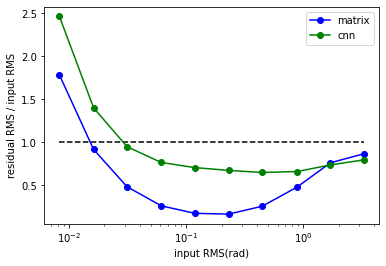

In [ ]:
#make RMS plot

#IMPORT MODEL
# model = keras.models.load_model("./models/testmodel")
# model.summary()

# test_per_image()


#make label wavefront and mvm reconstruction
label_wf = np.matmul(testy, modes_to_wf.transpose())*aperture
mvm_pred_modes = np.matmul((testx-image_ref).reshape(len(testx), num_pwfs_pixels**2), matrix.transpose())
mvm_pred_wf = np.matmul(mvm_pred_modes, modes_to_wf.transpose())*aperture


#normalize data and make cnn reconstruction
cnn_data = np.ndarray((len(testx), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4))
h = int(num_pwfs_pixels/2)
cnn_data[:,:,:,0] = testx[:, :h, :h]
cnn_data[:,:,:,1] = testx[:, h:, :h]
cnn_data[:,:,:,2] = testx[:, :h, h:]
cnn_data[:,:,:,3] = testx[:, h:, h:]

data_vars = np.sqrt(np.var(cnn_data, axis=1))
label_var = np.sqrt(np.var(testy))
cnn_pred_modes = model.predict(cnn_data / data_vars[:,None]) * label_var
cnn_pred_wf = np.matmul(cnn_pred_modes, modes_to_wf.transpose())

label_wf *= aperture
cnn_pred_wf *= aperture
mvm_pred_wf *= aperture



#calculate RMS
inputs = []
mvm_outputs = []
cnn_outputs = []
for i in range(len(rmslist)):
    print(i)
    input_rms = get_rms(label_wf[i*nr_runs:(i+1)*nr_runs]**2) * to_rad
    matrix_rms = get_rms(mvm_pred_wf[i*nr_runs:(i+1)*nr_runs] - label_wf[i*nr_runs:(i+1)*nr_runs]) * to_rad
    cnn_rms = get_rms(cnn_pred_wf[i*nr_runs:(i+1)*nr_runs] - label_wf[i*nr_runs:(i+1)*nr_runs]) * to_rad
    
    inputs.append(np.mean(input_rms))
    mvm_outputs.append(np.mean(matrix_rms/input_rms))
    cnn_outputs.append(np.mean(cnn_rms/input_rms))
  
plt.hlines(1, np.min(inputs), np.max(inputs), linestyles="dashed")
plt.semilogx(inputs, mvm_outputs, marker="o", color="blue", label="matrix")
plt.semilogx(inputs, cnn_outputs, marker="o", color="green", label="cnn")
plt.xlabel("input RMS(rad)")
plt.ylabel("residual RMS / input RMS")
plt.legend()
plt.show()

#Make closed loop animation


0 200
0 200
10 200
20 200
30 200
40 200
50 200
60 200
70 200
80 200
90 200
100 200
110 200
120 200
130 200
140 200
150 200
160 200
170 200
180 200
190 200
0 200


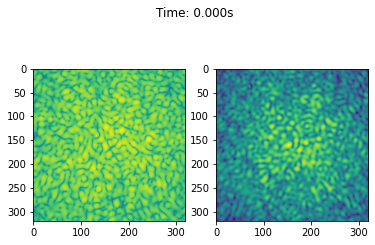

In [61]:
#generic atmospheric parameters
# seeing = 0.1
seeing = 0.6 # arcsec @ 500nm (convention)
outer_scale = telescope_diameter # meter
tau0 = 0.01 # seconds
fried_parameter = seeing_to_fried_parameter(seeing)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 1e-6)
velocity = 0.314 * fried_parameter / tau0
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)


#simulation parameters
gain = 0.6
leakage = 0.01
num_iterations = 200
burn_in_iterations = 5
delta_t = 1e-3   #1 kHz


long_exposure = focal_grid.zeros()
propagator = FraunhoferPropagator(pupil_grid, focal_grid)
deformable_mirror.flatten()
# coro = PerfectCoronagraph(aperture, 4)
# long_exposure_coro = focal_grid.zeros()

paramtext = "closed_loop_mvm_{}".format(mod_text)


def cnnreconstruction(pwfs_img):
  cnn_data = np.ndarray((len(pwfs_img), int(num_pwfs_pixels/2), int(num_pwfs_pixels/2), 4))
  h = int(num_pwfs_pixels/2)
  cnn_data[:,:,:,0] = pwfs_img[:, :h, :h]
  cnn_data[:,:,:,1] = pwfs_img[:, h:, :h]
  cnn_data[:,:,:,2] = pwfs_img[:, :h, h:]
  cnn_data[:,:,:,3] = pwfs_img[:, h:, h:]

  data_vars = np.sqrt(np.var(cnn_data, axis=1))
  label_vars = np.sqrt(np.var(testy, axis=1))
  cnn_pred_modes = model.predict(cnn_data / data_vars[:,None]) * label_vars[:,None]
  cnn_pred_wf = np.matmul(cnn_pred_modes, modes_to_wf.transpose())


def update(frame, long_exposure):
  layer.t = frame*delta_t

  wf_atm = layer.forward(wf_flat) 
  wf_dm = deformable_mirror.forward(wf_atm)
  if use_modulation:
    wf_pwfs = mpwfs.forward(wf_dm)
    wf_pwfs = modavg(wf_pwfs)
  else:
    wf_pwfs = pwfs.forward(wf_dm).intensity
    wf_pwfs /= np.sum(wf_pwfs)


  # reconstruction = cnnreconstruction(wf_pwfs)
  reconstruction = np.matmul(wf_pwfs, matrix.transpose())
  deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators - gain * reconstruction

  psf = propagator.forward(wf_dm)
  long_exposure += psf.power / num_iterations

  plt.suptitle('Time: {:.3f}s'.format(frame*delta_t))

  ax[0].cla()
  ax[0].imshow(np.log10(psf.power / psf.power.max()).reshape(num_focal_pixels, num_focal_pixels))

  ax[1].cla()
  ax[1].imshow(np.log10(long_exposure/long_exposure.max()).reshape(num_focal_pixels, num_focal_pixels))

  if frame%10 == 0:
    print(frame, num_iterations)


fig, ax = plt.subplots(1, 2)
ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
anim = animation.FuncAnimation(fig, update, fargs=(long_exposure,), frames=num_iterations)
simulation_time = 3 #num_iterations * delta_t
writer = animation.FFMpegWriter(fps=num_iterations/simulation_time)
anim.save("{}.mp4".format(paramtext), writer=writer)

#Debug

In [ ]:
def test_per_image():
    for i in range(len(rmslist)):
        dm_state = testy[i*100]
        print(testx[i].reshape(1, 64, 64, 4).shape)
        cnn_pred = model.predict((testx[i*100] / np.sqrt(np.var(testx[i*100]))).reshape(1, 64, 64, 4)) * np.sqrt(np.var(testy[i*100]))
        plt.imshow((dm_state - cnn_pred).reshape(20, 20))
        plt.colorbar()
        plt.title("difference")
        plt.show()
        # print(dm_state)
        plt.imshow(dm_state.reshape(20, 20))
        plt.colorbar()
        plt.title("label")
        plt.show()
        # print(cnn_pred)
        plt.imshow(cnn_pred.reshape(20, 20))
        plt.colorbar()
        plt.title("prediction")
        plt.show()
    asdadsads